   Unnamed: 0                tmsp  country  amount  success         PSP  \
0           0 2019-01-01 00:01:11  Germany      89        0     UK_Card   
1           1 2019-01-01 00:01:17  Germany      89        1     UK_Card   
2           2 2019-01-01 00:02:49  Germany     238        0     UK_Card   
3           3 2019-01-01 00:03:13  Germany     238        1     UK_Card   
4           4 2019-01-01 00:04:33  Austria     124        0  Simplecard   

   3D_secured    card  
0           0    Visa  
1           0    Visa  
2           1  Diners  
3           1  Diners  
4           0  Diners  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  50410 non-null  int64         
 1   tmsp        50410 non-null  datetime64[ns]
 2   country     50410 non-null  object        
 3   amount      50410 non-null  int64         
 4   succ

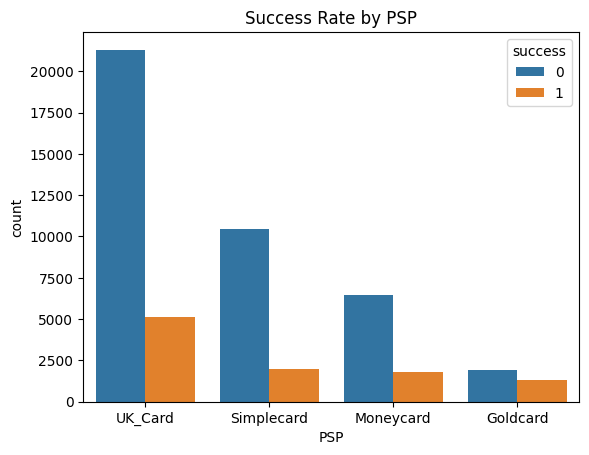

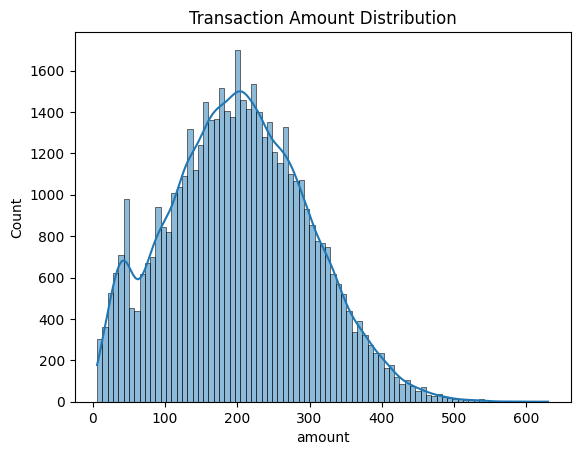

Unique encoded PSPs: [3 2 1 0]
Random Forest Accuracy: 0.7393374330489982
[[10597  1582]
 [ 2360   584]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.84     12179
           1       0.27      0.20      0.23      2944

    accuracy                           0.74     15123
   macro avg       0.54      0.53      0.54     15123
weighted avg       0.71      0.74      0.72     15123

XGBoost Accuracy: 0.8081729815512795
[[12082    97]
 [ 2804   140]]
              precision    recall  f1-score   support

           0       0.81      0.99      0.89     12179
           1       0.59      0.05      0.09      2944

    accuracy                           0.81     15123
   macro avg       0.70      0.52      0.49     15123
weighted avg       0.77      0.81      0.74     15123



NameError: name 'shap' is not defined

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Load the dataset (assuming the data is in a CSV after unzipping)
data = pd.read_excel("PSP_Jan_Feb_2019.xlsx")

# Data Understanding: Inspecting the data
print(data.head())
print(data.info())

# Convert `tmsp` to datetime
data['tmsp'] = pd.to_datetime(data['tmsp'])

# Initial Exploratory Data Analysis (EDA)
# Plot success rate by PSP
sns.countplot(x='PSP', hue='success', data=data)
plt.title('Success Rate by PSP')
plt.show()

# Plot distribution of transaction amount
sns.histplot(data['amount'], kde=True)
plt.title('Transaction Amount Distribution')
plt.show()

# Grouping transaction attempts within one minute as a single purchase attempt
data.sort_values(['tmsp'], inplace=True)
data['retry'] = data.groupby(['country', 'amount'])['tmsp'].diff().dt.total_seconds().lt(60).astype(int)

# Define the list of all possible PSPs (whether or not present in the dataset)
expected_psps = ['Moneycard', 'Goldcard', 'UK_Card', 'Simplecard']

# Fit the LabelEncoder on all expected PSPs
le = LabelEncoder()
le.fit(expected_psps)

# Apply the LabelEncoder to the 'PSP' column in the dataset
data['PSP_encoded'] = data['PSP'].apply(lambda x: le.transform([x])[0] if x in expected_psps else None)

# Handle missing or unknown PSPs safely (if any PSP isn't in the expected list, it'll be marked as `None` and handled accordingly)
print("Unique encoded PSPs:", data['PSP_encoded'].unique())

# Convert other categorical variables
data['country'] = le.fit_transform(data['country'])
data['card'] = le.fit_transform(data['card'])

# Select features and target variable
X = data[['country', 'amount', 'PSP_encoded', '3D_secured', 'card', 'retry']]
y = data['success']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Baseline Model: Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Advanced Model: XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions and Evaluation for XGBoost
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

# Feature Importance with SHAP for XGBoost
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)  # Updated shap explainer usage

# Plot feature importance
shap.summary_plot(shap_values, X_test)

# Error Analysis: Investigate misclassifications
errors = X_test[y_test != y_pred_xgb]
print("Error Analysis:")
print(errors)

# Cost-benefit analysis based on PSP selection and associated fees
# PSP Fee Structure Mapping
success_fee = {
    'Moneycard': 5,
    'Goldcard': 10,
    'UK_Card': 3,
    'Simplecard': 1
}

failure_fee = {
    'Moneycard': 2,
    'Goldcard': 5,
    'UK_Card': 1,
    'Simplecard': 0.5
}

# Cost Calculation Function
def calculate_cost(row):
    psp = row['PSP']  # Use original PSP name for cost calculation
    if row['success'] == 1:
        return success_fee.get(psp, 0)
    else:
        return failure_fee.get(psp, 0)

# Apply the cost function to each row in the dataset
data['cost'] = data.apply(calculate_cost, axis=1)

# Calculate total cost
total_cost = data['cost'].sum()
print(f"Total Transaction Cost: {total_cost} Euros")
